# Project: ij-blocking

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import re
import pickle

In [3]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results(out_field, k_lev = 32, if_plot = True):
    
    num_tests = len(out_field)
    
    if if_plot:
        if num_tests > 4:
            fig, axs = plt.subplots(2, num_tests//2, figsize=(12, 8))
            axs = axs.flatten()

        else:
            fig, axs = plt.subplots(1, num_tests, figsize=(12, 4))

    test_diff = np.zeros(num_tests-1)
    
    for i, (key,data) in enumerate(out_field.items()):
        if i == 0:
            k_data = data
        if if_plot:
            im1 = axs[i].imshow(data[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
            fig.colorbar(im1, ax=axs[i]);
            axs[i].set_title(key)
        if i > 0:
            test_diff[i-1] = np.sum(np.abs(k_data-data))
    plt.show()
    
    if sum(test_diff) != 0:
        print('MAE', np.array(test_diff)/ np.prod(k_data.shape))
        print(list(out_field.keys())[1:])
        return False
    return True
    

    


In [3]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

versions=('kblocking' 'complexity-copy' 'ijblocking-math' 'ijblocking2' 'averaging-nn' 'averaging-nnn' 'complexity-0' 'complexity-1' 'lap-nn-ij' 'lap-nnn-ij' 'ijblocking-inline' 'ijblocking-small' ) ## THIS SHOULD BE A COPY OF VERSIONS IN CELL BELOW


echo "===== cleaning up ====="
make clean
echo "===== compiling ====="
for version in "${versions[@]}"
do 
       make VERSION="$version"
done

===== cleaning up =====
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
===== compiling =====
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-kblocking.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-kblocking.o -o stencil2d-kblocking.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-kblocking.x' (lite-samples) ...OK


cp stencil2d-kblocking.x stencil2d.x


make: *** No rule to make target 'stencil2d-complexity-copy.o', needed by 'stencil2d-complexity-copy.x'.  Stop.


ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-ijblocking-math.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-ijblocking-math.o -o stencil2d-ijblocking-math.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-ijblocking-math.x' (lite-samples) ...OK


cp stencil2d-ijblocking-math.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-ijblocking2.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-ijblocking2.o -o stencil2d-ijblocking2.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-ijblocking2.x' (lite-samples) ...OK


cp stencil2d-ijblocking2.x stencil2d.x


make: *** No rule to make target 'stencil2d-averaging-nn.o', needed by 'stencil2d-averaging-nn.x'.  Stop.
make: *** No rule to make target 'stencil2d-averaging-nnn.o', needed by 'stencil2d-averaging-nnn.x'.  Stop.
make: *** No rule to make target 'stencil2d-complexity-0.o', needed by 'stencil2d-complexity-0.x'.  Stop.
make: *** No rule to make target 'stencil2d-complexity-1.o', needed by 'stencil2d-complexity-1.x'.  Stop.


ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-lap-nn-ij.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-lap-nn-ij.o -o stencil2d-lap-nn-ij.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-lap-nn-ij.x' (lite-samples) ...OK


cp stencil2d-lap-nn-ij.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-lap-nnn-ij.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-lap-nnn-ij.o -o stencil2d-lap-nnn-ij.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-lap-nnn-ij.x' (lite-samples) ...OK


cp stencil2d-lap-nnn-ij.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-ijblocking-inline.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-ijblocking-inline.o -o stencil2d-ijblocking-inline.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-ijblocking-inline.x' (lite-samples) ...OK


cp stencil2d-ijblocking-inline.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-ijblocking-small.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-ijblocking-small.o -o stencil2d-ijblocking-small.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-ijblocking-small.x' (lite-samples) ...OK


cp stencil2d-ijblocking-small.x stencil2d.x


In [ ]:
# srun slurm comand to start a job
# -n number of processes requested

versions = ['kblocking', 'ijblocking-small', 'ijblocking-inline', 'ijblocking-math', 'ijblocking2',] ## THIS SHOULD BE A COPY OF VERSIONS IN CELL ABOVE


output = {}
out_field = {}

nx = np.array([64,128,256,512,1024,2048])
ny = np.array([64])
size_i = np.array([32])
size_j = np.array([32])
num_iter = 256
nz = 16

      
if versions[0] != 'kblocking':
    sys.exit('kblocking has to be first in versions. Leads to error in comparisons')

runtimes = {key: np.zeros((len(nx)*len(ny)*len(size_i)*len(size_j),5)) for key in versions}
ii_index = 0
for nx_ in nx:
    for ny_ in ny:
        for size_i_ in size_i:
            
            for size_j_ in size_j:
                if size_i_>= nx_:
                    continue
                if size_j_ >= ny_:
                    continue
                for version in versions:
                    command = f"srun -n 1 ./stencil2d-{version}.x+orig --nx {nx_} --ny {ny_} --nz {nz} --size_i {size_i_} --size_j {size_j_} --num_iter {num_iter}"
                    

                    if version == 'kblocking' :
                        
                        command = f"srun -n 1 ./stencil2d-{version}.x+orig --nx {nx_} --ny {ny_} --nz {nz} --num_iter {num_iter}"
                        
                        

                    print(command)
                    out =  !{command}
                    print(out)
                    output.update({version: out})
                    #out_field.update({version: read_field_from_file('out_field.dat')})

                #validate_results(out_field, if_plot=False)
                pattern = r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?"
                for i, (key, value) in enumerate(output.items()):
                    
                    try:
                        runtimes[key][ii_index] = [nx_,ny_,size_i_,size_j_,float(re.findall(pattern, value[2])[-1])]
                    except:
                        runtimes[key][ii_index] = [nx_,ny_,size_i_,size_j_,np.nan]

                        
                        
                ii_index+=1
                print('\n ============================= \n')


with open('saved_runtimes_nx.pkl', 'wb') as f:
    pickle.dump(runtimes, f)

srun -n 1 ./stencil2d-kblocking.x+orig --nx 64 --ny 64 --nz 16 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1,   64,   64,   16,     256,  0.2360129E-01], \\', '] )']
srun -n 1 ./stencil2d-ijblocking-small.x+orig --nx 64 --ny 64 --nz 16 --size_i 32 --size_j 32 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1,   64,   64,   16,     256,  0.2896929E-01], \\', '] )']
srun -n 1 ./stencil2d-ijblocking-inline.x+orig --nx 64 --ny 64 --nz 16 --size_i 32 --size_j 32 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1,   64,   64,   16,     256,  0.5224586E-01], \\', '] )']
srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 64 --ny 64 --nz 16 --size_i 32 --size_j 32 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1,   64,   64,   16,     256,  0.2103090E-01], \\', '] )']
srun -n 1 ./stencil2d-ijblocking2.x+orig --nx 64 --ny 64 --nz 16 --size_i 32 --size_j 32 --num_

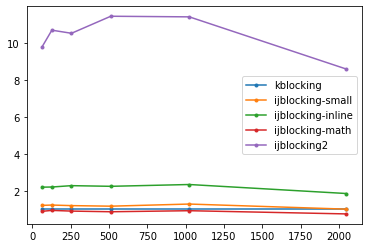

In [5]:
for i, ver in enumerate(versions):
    plt.plot(runtimes_nx[versions[i]][:,0],runtimes_nx[versions[i]][:,-1]/runtimes_nx[versions[0]][:,-1], '.-',label = ver)
    
plt.legend()

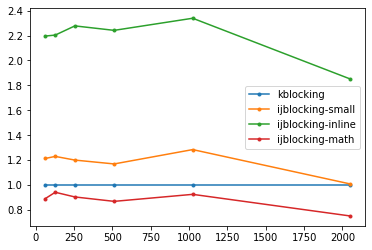

In [11]:
for i, ver in enumerate(versions[:-1]):
    plt.plot(runtimes_nx[versions[i]][:,0],runtimes_nx[versions[i]][:,-1]/runtimes_nx[versions[0]][:,-1], '.-',label = ver)
    
plt.legend()

In [6]:
# srun slurm comand to start a job
# -n number of processes requested

versions = ['kblocking', 'ijblocking-small', 'ijblocking-inline', 'ijblocking-math', 'ijblocking2',] ## THIS SHOULD BE A COPY OF VERSIONS IN CELL ABOVE


output = {}
out_field = {}

ny = np.array([64,128,256,512,1024,2048])
size_i = np.array([32])
size_j = np.array([32])
num_iter = 256
nz = 16

      
if versions[0] != 'kblocking':
    sys.exit('kblocking has to be first in versions. Leads to error in comparisons')

runtimes_ny = {key: np.zeros((len(ny)*len(size_i)*len(size_j),5)) for key in versions}
ii_index = 0
for ny_ in ny:
    nx_ = ny_
    for size_i_ in size_i:

        for size_j_ in size_j:
            if size_i_>= nx_:
                continue
            if size_j_ >= ny_:
                continue
            for version in versions:
                command = f"srun -n 1 ./stencil2d-{version}.x+orig --nx {nx_} --ny {ny_} --nz {nz} --size_i {size_i_} --size_j {size_j_} --num_iter {num_iter}"


                if version == 'kblocking' :

                    command = f"srun -n 1 ./stencil2d-{version}.x+orig --nx {nx_} --ny {ny_} --nz {nz} --num_iter {num_iter}"



                print(command)
                out =  !{command}
                print(out)
                output.update({version: out})
                #out_field.update({version: read_field_from_file('out_field.dat')})

            #validate_results(out_field, if_plot=False)
            pattern = r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?"
            for i, (key, value) in enumerate(output.items()):

                try:
                    runtimes_ny[key][ii_index] = [nx_,ny_,size_i_,size_j_,float(re.findall(pattern, value[2])[-1])]
                except:
                    runtimes_ny[key][ii_index] = [nx_,ny_,size_i_,size_j_,np.nan]


            ii_index+=1
            print('\n ============================= \n')


with open('saved_runtimes_ny_nx.pkl', 'wb') as f:
    pickle.dump(runtimes_ny, f)

srun -n 1 ./stencil2d-kblocking.x+orig --nx 64 --ny 64 --nz 16 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1,   64,   64,   16,     256,  0.2445745E-01], \\', '] )']
srun -n 1 ./stencil2d-ijblocking-small.x+orig --nx 64 --ny 64 --nz 16 --size_i 32 --size_j 32 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1,   64,   64,   16,     256,  0.2844024E-01], \\', '] )']
srun -n 1 ./stencil2d-ijblocking-inline.x+orig --nx 64 --ny 64 --nz 16 --size_i 32 --size_j 32 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1,   64,   64,   16,     256,  0.5209184E-01], \\', '] )']
srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 64 --ny 64 --nz 16 --size_i 32 --size_j 32 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1,   64,   64,   16,     256,  0.2128148E-01], \\', '] )']
srun -n 1 ./stencil2d-ijblocking2.x+orig --nx 64 --ny 64 --nz 16 --size_i 32 --size_j 32 --num_

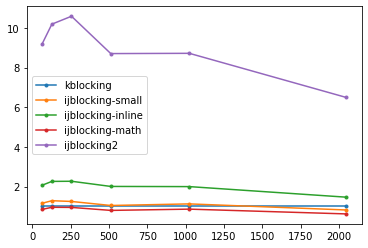

In [9]:
for i, ver in enumerate(versions):
    plt.plot(runtimes_ny[versions[i]][:,1],runtimes_ny[versions[i]][:,-1]/runtimes_ny[versions[0]][:,-1], '.-',label = ver)
    
plt.legend()

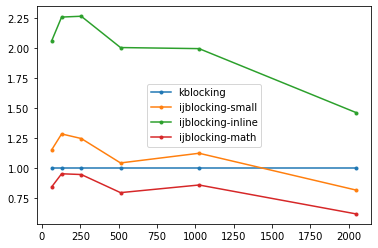

In [10]:
for i, ver in enumerate(versions[:-1]):
    plt.plot(runtimes_ny[versions[i]][:,1],runtimes_ny[versions[i]][:,-1]/runtimes_ny[versions[0]][:,-1], '.-',label = ver)
    
plt.legend()

In [ ]:
# srun slurm comand to start a job
# -n number of processes requested

versions = ['ijblocking-math'] ## THIS SHOULD BE A COPY OF VERSIONS IN CELL ABOVE


output = {}
out_field = {}

nx = np.array([1024*4])
ny = np.array([1024*4])

size_i = np.array([8,16,32,64,128,256,512,1024,2048])
size_j = np.array([8,16,32,64,128,256,512,1024,2048])

num_iter = 256
nz = 16


runtimes = {key: np.zeros((len(nx)*len(ny)*len(size_i)*len(size_j),5)) for key in versions}
ii_index = 0
for nx_ in nx:
    for ny_ in ny:
        for size_i_ in size_i:
            
            for size_j_ in size_j:
                if size_i_>= nx_:
                    continue
                if size_j_ >= ny_:
                    continue
                for version in versions:
                    command = f"srun -n 1 ./stencil2d-{version}.x+orig --nx {nx_} --ny {ny_} --nz {nz} --size_i {size_i_} --size_j {size_j_} --num_iter {num_iter}"
                    

                    if version == 'kblocking' :
                        
                        command = f"srun -n 1 ./stencil2d-{version}.x+orig --nx {nx_} --ny {ny_} --nz {nz} --num_iter {num_iter}"
                        
                        

                    print(command)
                    out =  !{command}
                    print(out)
                    output.update({version: out})
                    #out_field.update({version: read_field_from_file('out_field.dat')})

                #validate_results(out_field, if_plot=False)
                pattern = r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?"
                for i, (key, value) in enumerate(output.items()):
                    
                    try:
                        runtimes[key][ii_index] = [nx_,ny_,size_i_,size_j_,float(re.findall(pattern, value[2])[-1])]
                    except:
                        runtimes[key][ii_index] = [nx_,ny_,size_i_,size_j_,np.nan]

                        
                        
                ii_index+=1
                print('\n ============================= \n')


with open('saved_runtimes_i_j.pkl', 'wb') as f:
    pickle.dump(runtimes, f)

srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 4096 --ny 4096 --nz 16 --size_i 8 --size_j 8 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1, 4096, 4096,   16,     256,  0.1815789E+03], \\', '] )']


srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 4096 --ny 4096 --nz 16 --size_i 8 --size_j 16 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1, 4096, 4096,   16,     256,  0.2031301E+03], \\', '] )']


srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 4096 --ny 4096 --nz 16 --size_i 8 --size_j 32 --num_iter 256


In [4]:
# srun slurm comand to start a job
# -n number of processes requested

versions = ['ijblocking-math'] ## THIS SHOULD BE A COPY OF VERSIONS IN CELL ABOVE


output = {}
out_field = {}

nx = np.array([1024*2])
ny = np.array([1024*2])

size_i = np.array([8,16,32,64,128,256,512,1024,1024*2])
size_j = np.array([8,16,32,64,128,256,512,1024,1024*2])

num_iter = 256
nz = 16


runtimes = {key: np.zeros((len(nx)*len(ny)*len(size_i)*len(size_j),5)) for key in versions}
ii_index = 0
for nx_ in nx:
    for ny_ in ny:
        for size_i_ in size_i:
            
            for size_j_ in size_j:
                for version in versions:
                    command = f"srun -n 1 ./stencil2d-{version}.x+orig --nx {nx_} --ny {ny_} --nz {nz} --size_i {size_i_} --size_j {size_j_} --num_iter {num_iter}"
                    

                    if version == 'kblocking' :
                        
                        command = f"srun -n 1 ./stencil2d-{version}.x+orig --nx {nx_} --ny {ny_} --nz {nz} --num_iter {num_iter}"
                        
                        

                    print(command)
                    out =  !{command}
                    print(out)
                    output.update({version: out})
                    #out_field.update({version: read_field_from_file('out_field.dat')})

                #validate_results(out_field, if_plot=False)
                pattern = r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?"
                for i, (key, value) in enumerate(output.items()):
                    
                    try:
                        runtimes[key][ii_index] = [nx_,ny_,size_i_,size_j_,float(re.findall(pattern, value[2])[-1])]
                    except:
                        runtimes[key][ii_index] = [nx_,ny_,size_i_,size_j_,np.nan]

                        
                        
                ii_index+=1
                print('\n ============================= \n')


with open('saved_runtimes_i_j.pkl', 'wb') as f:
    pickle.dump(runtimes, f)

srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 2048 --ny 2048 --nz 16 --size_i 8 --size_j 8 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1, 2048, 2048,   16,     256,  0.4282228E+02], \\', '] )']


srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 2048 --ny 2048 --nz 16 --size_i 8 --size_j 16 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1, 2048, 2048,   16,     256,  0.4678597E+02], \\', '] )']


srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 2048 --ny 2048 --nz 16 --size_i 8 --size_j 32 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1, 2048, 2048,   16,     256,  0.6957234E+02], \\', '] )']


srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx 2048 --ny 2048 --nz 16 --size_i 8 --size_j 64 --num_iter 256
['# ranks nx ny nz num_iter time', 'data = np.array( [ \\', '[    1, 2048, 2048,   16,     256,  0.6639459E+02], \\', '] )']


srun -n 1 ./stencil2d-ijblocking-math.x+orig --nx